In [1]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.opflow import AerPauliExpectation, PauliSumOp
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

# Convolutional Layer

In [2]:
def conv_circuit(params):
    
    target = QuantumCircuit(2)
    target.rz(-np.pi/2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi/2, 0)
    
    return target

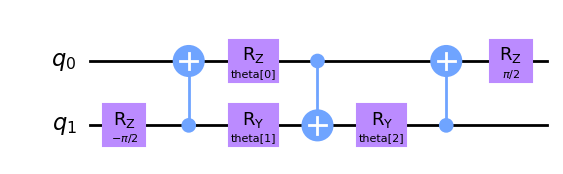

In [3]:
params = ParameterVector("theta", length=3)
circuit = conv_circuit(params=params)
circuit.draw("mpl")

In [4]:
def conv_layer(num_qubits, param_prefix):
    
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits*3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
        
    qc_inst = qc.to_instruction()
    
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    
    return qc

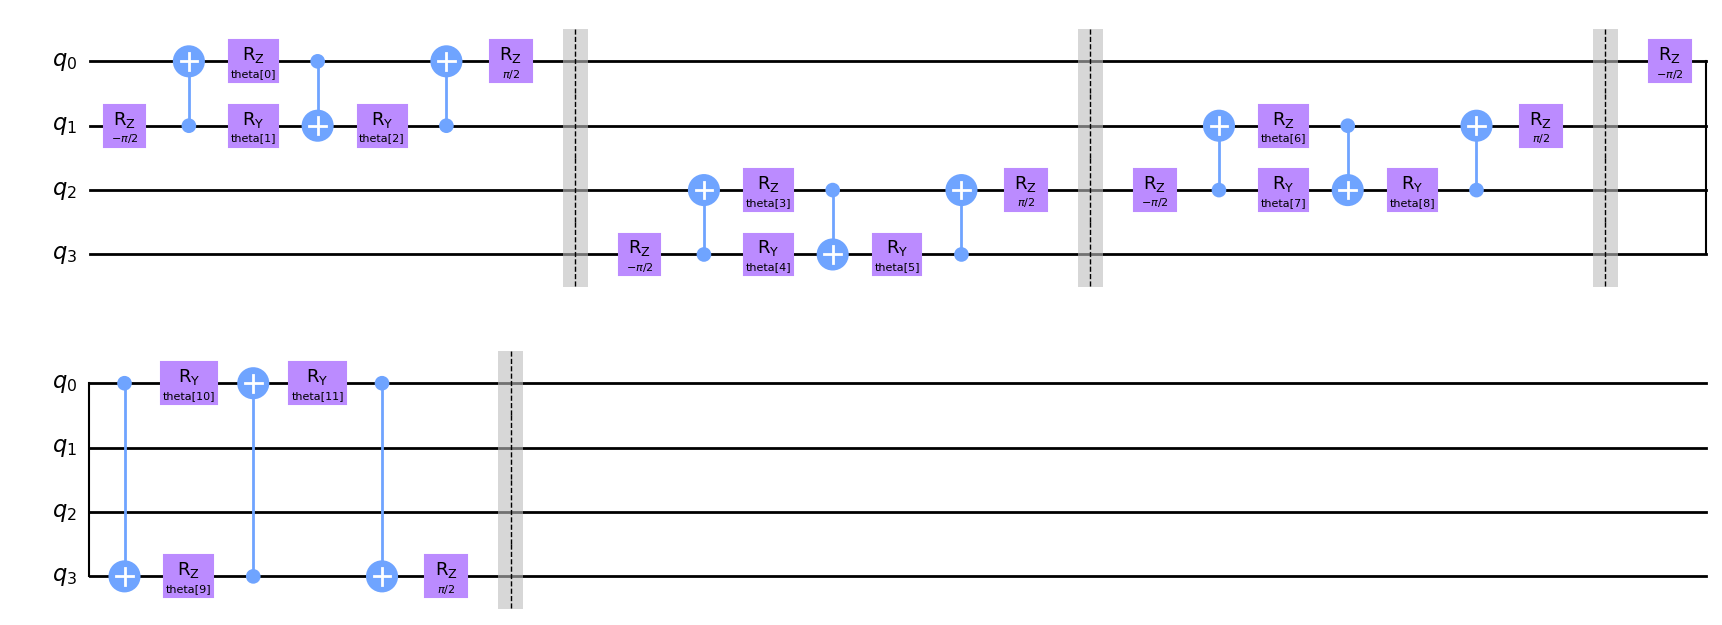

In [5]:
circuit = conv_layer(4, "theta")
circuit.decompose().draw("mpl")

# Pooling Layer

In [6]:
def pool_circuit(params):
    
    target = QuantumCircuit(2)
    target.rz(-np.pi/2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    
    return target

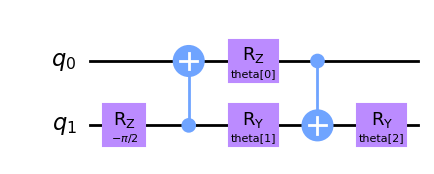

In [7]:
params = ParameterVector("theta", length=3)
circuit = pool_circuit(params=params)
circuit.draw("mpl")

In [8]:
def pool_layer(sources, sinks, param_prefix):
    
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3
        
    qc_inst = qc.to_instruction()
    
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    
    return qc

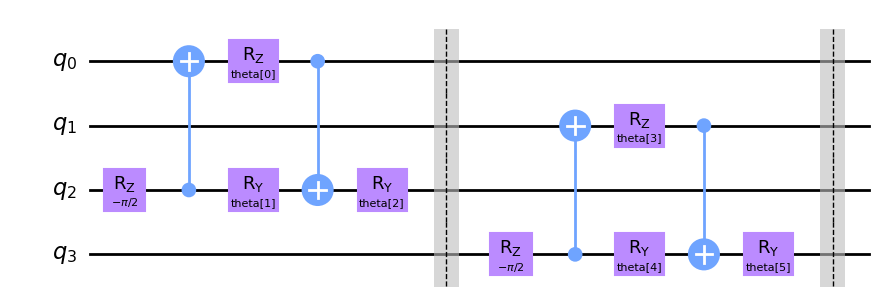

In [9]:
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "theta")
circuit.decompose().draw("mpl")

# Data Generation

In [10]:
def generate_dataset(num_images):
    
    images = []
    labels = []
    hor_array = np.zeros((12,16))
    ver_array = np.zeros((8,16))
    
    j = 0
    for i in range(0, 13):
        if i != 6:
            hor_array[j][i] = np.pi/2
            hor_array[j][i+1] = np.pi/2
            j += 1
            
    j = 0
    for i in range(0, 8):
        ver_array[j][i] = np.pi/2
        ver_array[j][i+4] = np.pi/2
        j += 1
        
    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 12)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 8)
            images.append(np.array(ver_array[random_image]))
            
        for i in range(16):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi/4)
                
    return images, labels

In [11]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(images,
                                                                        labels,
                                                                        test_size=0.3)

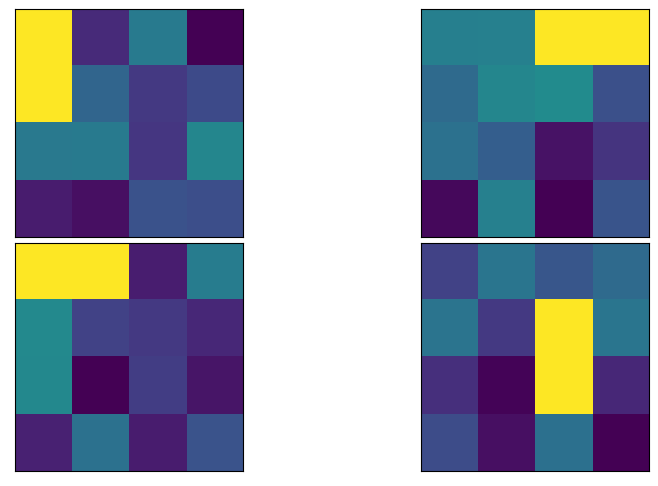

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})

for i in range(4):
    ax[i // 2, i%2].imshow(train_images[i].reshape(4,4),
                           aspect="equal")
    
plt.subplots_adjust(wspace=0.1, hspace=0.025)

# Modeling our QCNN

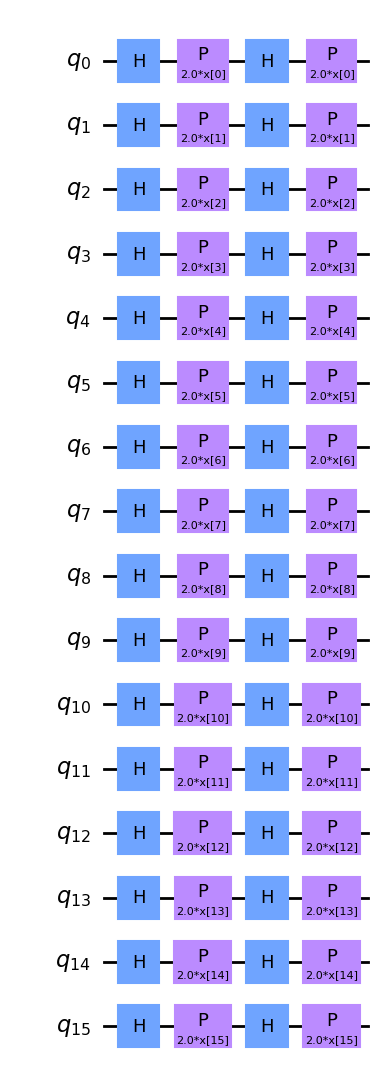

In [13]:
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

# Training our QCNN

In [14]:
qi = QuantumInstance(backend=Aer.get_backend("aer_simulator"), shots=2048)

feature_map = ZFeatureMap(16)

ansatz = QuantumCircuit(16, name="ansatz")

ansatz.compose(conv_layer(16, "c1"), list(range(16)), inplace=True)
ansatz.compose(pool_layer(list(range(8)), list(range(8,16)), "p1"),
               list(range(16)),
               inplace=True)

ansatz.compose(conv_layer(8, "c2"),
               list(range(8, 16)),
               inplace=True)
ansatz.compose(pool_layer(list(range(4)), list(range(4,8)), "p2"), list(range(8, 16)), inplace=True)

ansatz.compose(conv_layer(4, "c3"), list(range(12, 16)), inplace=True)
ansatz.compose(pool_layer(list(range(2)), list(range(2,4)), "p3"), list(range(12, 16)), inplace=True)

ansatz.compose(conv_layer(2, "c4"), list(range(14, 16)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p4"), list(range(14, 16)), inplace=True)

circuit = QuantumCircuit(16)
circuit.compose(feature_map, range(16), inplace=True)
circuit.compose(ansatz, range(16), inplace=True)

observable = PauliSumOp.from_list([("Z" + "I" * 15, 1)])

qnn = TwoLayerQNN(num_qubits=16,
                  feature_map=feature_map,
                  ansatz=ansatz,
                  observable=observable,
                  exp_val=AerPauliExpectation(),
                  quantum_instance=qi)

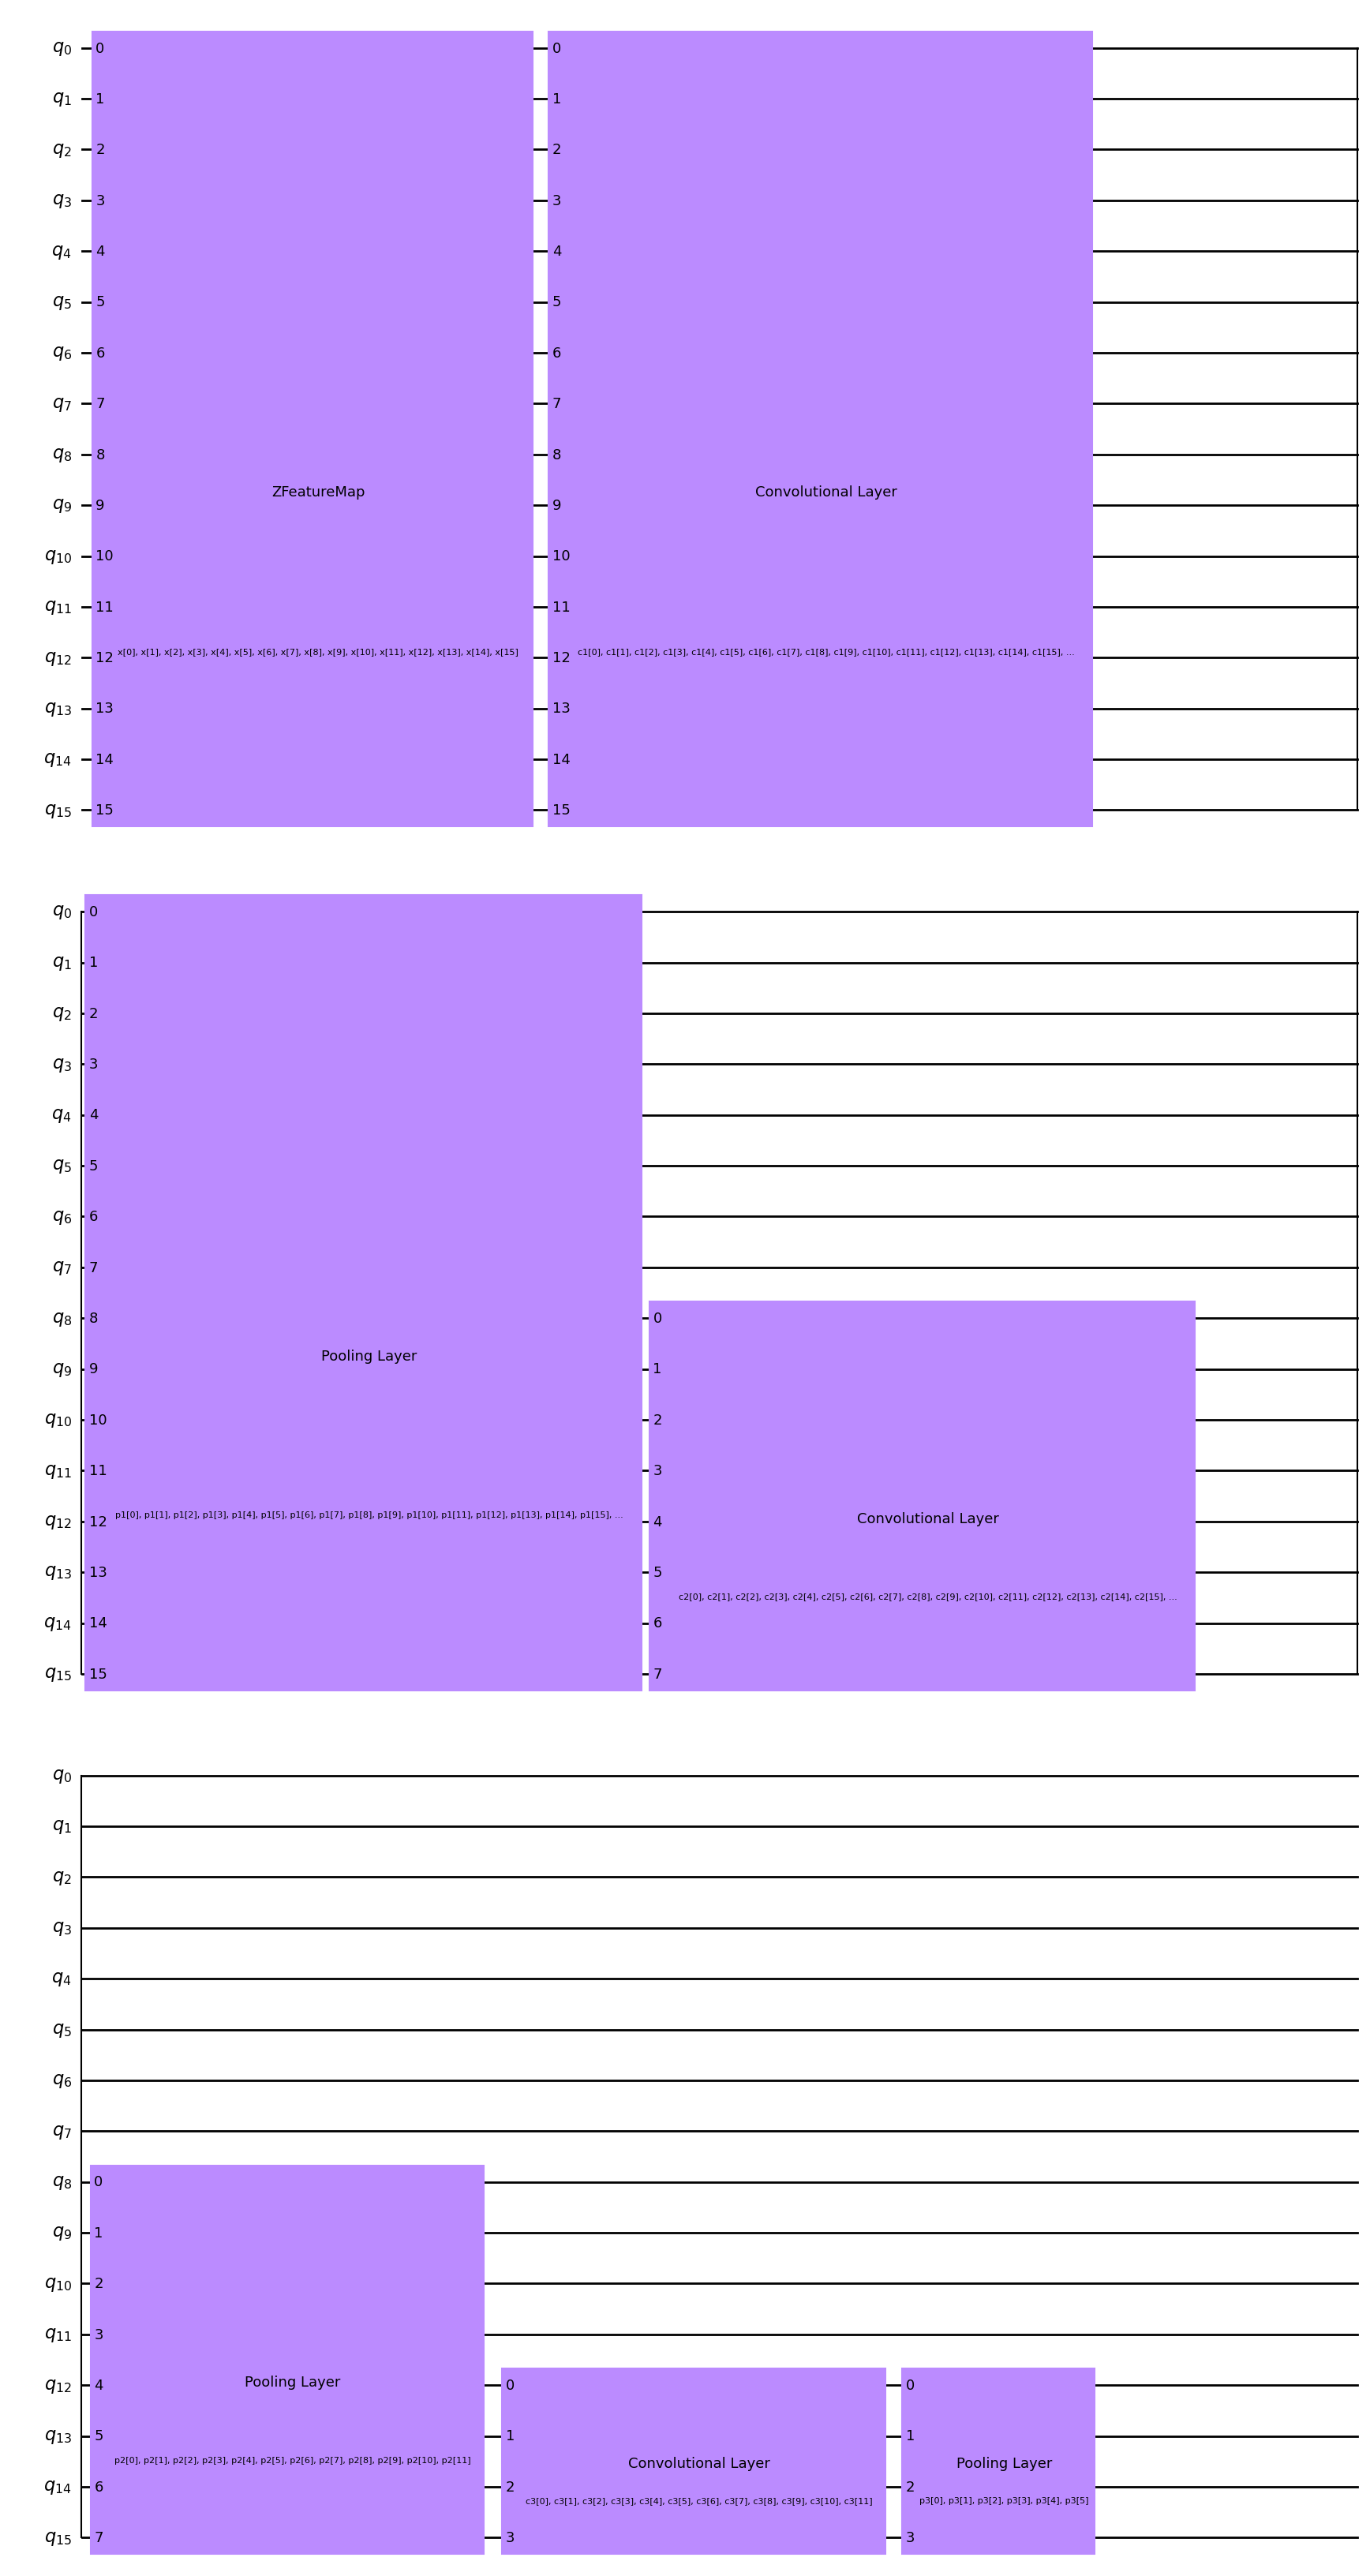

In [50]:
circuit.draw("mpl")

In [51]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [52]:
opflow_classifier = NeuralNetworkClassifier(qnn, 
                                            optimizer=COBYLA(maxiter=400), 
                                            callback=callback_graph,
                                            initial_point=algorithm_globals.random.random(qnn.num_weights))

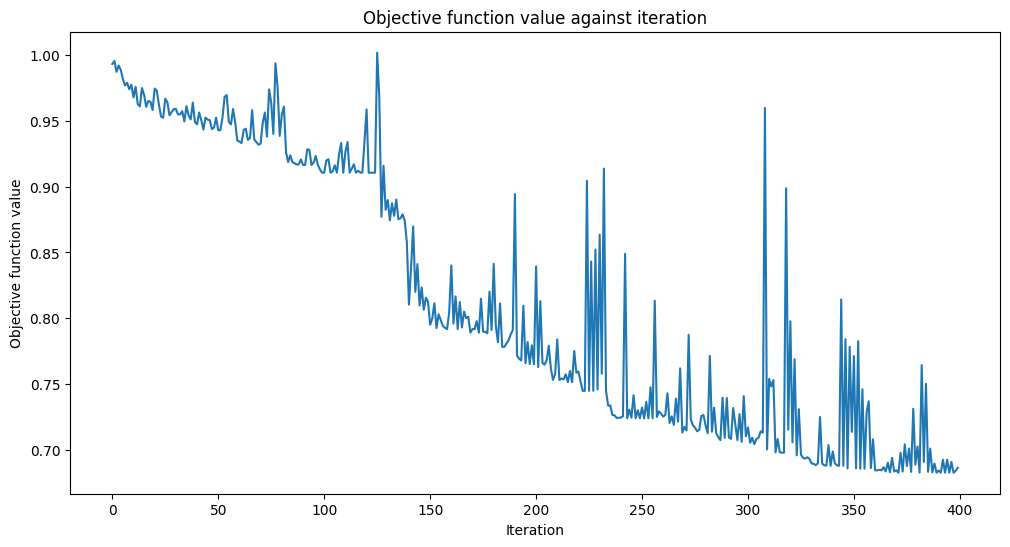

Accuracy from the train data: 80.0%


In [53]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
opflow_classifier.fit(x, y)

print(f"Accuracy from the train data: {np.round(100 * opflow_classifier.score(x,y), 2)}%")

Accuracy from the test data: 73.33%


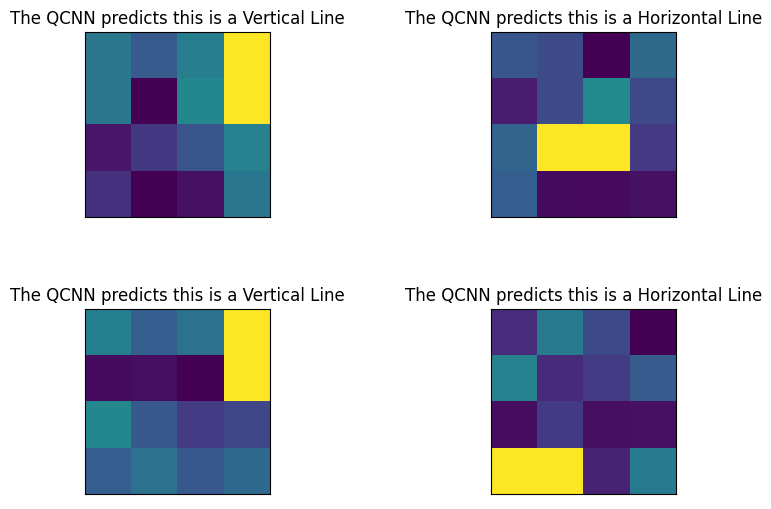

In [54]:
y_predict = opflow_classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data: {np.round(100 * opflow_classifier.score(x, y), 2)}%")

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(4,4), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [22]:
from __future__ import annotations


class QCNN:
    
    def __init__(self) -> QCNN:
        pass
    
    def _convolutional_circuit(self, params) -> QuantumCircuit:
        
        qc = QuantumCircuit(2)
        qc.rz(phi=-np.pi/2, qubit=1)
        qc.cx(control_qubit=1, target_qubit=0)
        qc.rz(phi=params[0], qubit=0)
        qc.ry(theta=params[1], qubit=1)
        qc.cx(control_qubit=0, target_qubit=1)
        qc.ry(theta=params[2], qubit=1)
        qc.cx(control_qubit=1, target_qubit=0)
        qc.rz(phi=np.pi/2, qubit=0)
        
        return qc
    
    def convolutional_layer(self, num_qubits: int) -> QuantumCircuit:
        
        qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
        qubits = list(range(num_qubits))
        param_index = 0
        params = ParameterVector("x", length=num_qubits*3)
        for q1, q2 in zip(qubits[0::2], qubits[1::2]):
            
            qc = qc.compose(self._convolutional_circuit(params=params[param_index : (param_index + 3)]), qubits=[q1, q2])
            qc.barrier()
            param_index += 3
            
        for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
            
            qc = qc.compose(self._convolutional_circuit(params=params[param_index : (param_index + 3)]), qubits=[q1, q2])
            qc.barrier()
            param_index += 3
            
        instructions = qc.to_instruction()
        
        qc = QuantumCircuit(num_qubits)
        qc.append(instruction=instructions, qargs=qubits)
        
        return qc
    
    def _pooling_circuit(self, params) -> QuantumCircuit:
        
        qc = QuantumCircuit(2)
        qc.rz(phi=-np.pi/2, qubit=1)
        qc.cx(control_qubit=1, target_qubit=0)
        qc.rz(phi=params[0], qubit=0)
        qc.ry(theta=params[1], qubit=1)
        qc.cx(control_qubit=0, target_qubit=1)
        qc.ry(theta=params[2], qubit=1)
        
        return qc
    
    def pooling_layer(self, sources, sinks) -> QuantumCircuit:
        
        num_qubits = len(sources) + len(sinks)
        qc = QuantumCircuit(num_qubits, name="Pooling Layer")
        param_index = 0
        params = ParameterVector("x", length=num_qubits // 2 * 3)
        
        for source, sink in zip(sources, sinks):
            
            qc = qc.compose(self._pooling_circuit(params=params[param_index : (param_index + 3)]), [source, sink])
            qc.barrier()
            param_index += 3
            
        instructions = qc.to_instruction()
        
        qc = QuantumCircuit(num_qubits)
        qc.append(instruction=instructions, qargs=range(num_qubits))
        
        return qc
            